# Базовая U-Net на Луне

In [188]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

class MoonSegmentationDataset(Dataset):

    def __init__(self, root_dir, image_folder='render', mask_folder='ground', 
                 image_ids=None, augmentation=None, preprocessing=None):
        self.root_dir = root_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
        images_dir = os.path.join(root_dir, 'images', image_folder)
        masks_dir = os.path.join(root_dir, 'images', mask_folder)
        
        if image_ids is None:
            all_images = os.listdir(images_dir)
            self.image_ids = [img.replace('.png', '') for img in all_images if img.endswith('.png')]
        else:
            self.image_ids = image_ids
        
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        
        image_path = os.path.join(self.root_dir, 'images', self.image_folder, f"{image_id}.png")
        
        # Для масок убираем префикс "render" если он есть
        # Например: render0001 - 0001
        mask_id = image_id.replace('render', '') if 'render' in image_id else image_id
        mask_path = os.path.join(self.root_dir, 'images', self.mask_folder, f"ground{mask_id}.png")
        
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Так как используем opencv, то не забываем преводить из BGR в RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Нормализуем бинарную маску к [0, 1]
        # 0 = фон, 1 = камни
        mask = (mask > 0).astype(np.float32)
        
        # Применяем аугментации
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # Применяем предобработку
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image, mask
    
train_augmentation = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0)),
        A.GaussianBlur(blur_limit=(3, 7)),
        A.MedianBlur(blur_limit=5),
    ], p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
])

preprocessing = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_augmentation = A.Compose([
    A.Resize(256, 256),
])

In [ ]:
# Путь к данным
DATA_ROOT = "../data/MOON_SEGMENTATION_BINARY/"

images_dir = os.path.join(DATA_ROOT, 'images', 'render')
all_images = [img.replace('.png', '') for img in os.listdir(images_dir) if img.endswith('.png')][:100]

print(f"Всего изображений: {len(all_images)}")

train_ids, val_ids = train_test_split(all_images, test_size=0.2, random_state=42)

print(f"Train: {len(train_ids)} изображений")
print(f"Val: {len(val_ids)} изображений")

train_dataset = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=train_ids,
    augmentation=train_augmentation,
    preprocessing=preprocessing
)

val_dataset = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=val_ids,
    augmentation=val_augmentation,
    preprocessing=preprocessing
)

BATCH_SIZE = 64
NUM_WORKERS = 0

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Батчей в train: {len(train_loader)}")
print(f"Батчей в val: {len(val_loader)}")

Всего изображений: 100
Train: 80 изображений
Val: 20 изображений
Батчей в train: 3
Батчей в val: 1


Размер батча изображений: torch.Size([32, 3, 256, 256])
Размер батча масок: torch.Size([32, 256, 256])


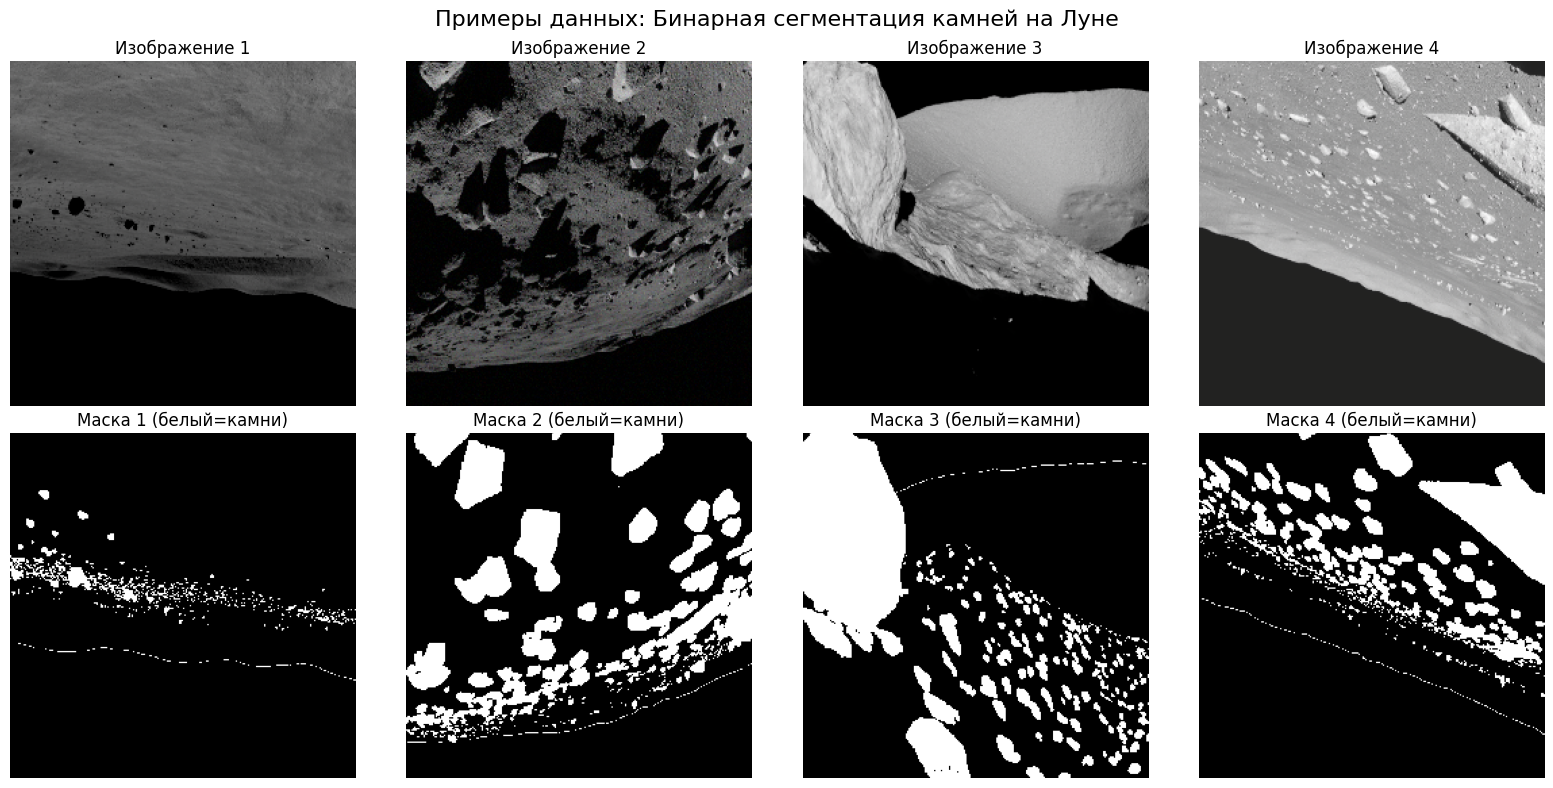

In [190]:
def denormalize(img_tensor):
    """Денормализация изображения для визуализации"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)

images, masks = next(iter(train_loader))

print(f"Размер батча изображений: {images.shape}")
print(f"Размер батча масок: {masks.shape}")

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(min(4, len(images))):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    mask = masks[i].numpy()
    
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Изображение {i+1}")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(mask, cmap='gray')
    axes[1, i].set_title(f"Маска {i+1} (белый=камни)")
    axes[1, i].axis('off')

plt.suptitle("Примеры данных: Бинарная сегментация камней на Луне", fontsize=16)
plt.tight_layout()
plt.show()

In [191]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

In [ ]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        
        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        prev_channels = in_channels
        for feature in features:
            self.encoder_blocks.append(DoubleConv(prev_channels, feature))
            prev_channels = feature

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        for feature in reversed(features):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.decoder_blocks.append(
                DoubleConv(feature * 2, feature)
            )

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        

        self.sigmoid = nn.Sigmoid()

        total_params = sum(p.numel() for p in self.parameters())
        print(f"Параметров: {total_params:,}")
        print(f"Уровней encoder: {len(features)}")
        print(f"Конфигурация каналов: {features}")
    
    def forward(self, x):

        skip_connections = []

        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)
            
            skip_connection = skip_connections[idx // 2]
            
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], 
                                mode='bilinear', align_corners=True)
            
            x = torch.cat([skip_connection, x], dim=1)
            
            x = self.decoder_blocks[idx + 1](x)

        output = self.final_conv(x)
        
        return output


model = UNet(in_channels=3, out_channels=1, features=[19, 38, 76, 152])

test_input = torch.randn(1, 3, 256, 256)
test_output = model(test_input)

print(f"   Вход:  {test_input.shape}")
print(f"   Выход: {test_output.shape}")

Параметров: 2,740,276
Уровней encoder: 4
Конфигурация каналов: [19, 38, 76, 152]
   Вход:  torch.Size([1, 3, 256, 256])
   Выход: torch.Size([1, 1, 256, 256])


In [ ]:
class DiceLoss(nn.Module):
    """
    Dice Loss для бинарной сегментации
    
    Dice = 2 * |X ∩ Y| / (|X| + |Y|)
    """
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, predictions, targets):
        predictions = torch.sigmoid(predictions)
        
        # Flatten
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        
        # Dice coefficient
        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)
        
        # Dice loss
        return 1 - dice


class CombinedLoss(nn.Module):

    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
    
    def forward(self, predictions, targets):
        bce_loss = self.bce(predictions, targets)
        dice_loss = self.dice(predictions, targets)
        
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss


def dice_coefficient(predictions, targets, threshold=0.5, smooth=1e-6):

    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    intersection = (predictions * targets).sum()
    dice = (2. * intersection + smooth) / (predictions.sum() + targets.sum() + smooth)
    
    return dice.item()


def iou_score(predictions, targets, threshold=0.5, smooth=1e-6):

    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    intersection = (predictions * targets).sum()
    union = predictions.sum() + targets.sum() - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    
    return iou.item()


def pixel_accuracy(predictions, targets, threshold=0.5):

    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    correct = (predictions == targets).float().sum()
    total = targets.numel()
    
    return (correct / total).item()

In [210]:
def train_epoch(model, train_loader, criterion, optimizer, device):

    model.train()
    
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    
    pbar = tqdm(train_loader, desc="Training")
    
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, masks)
        
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
        
        running_loss += loss.item()
        running_dice += dice
        running_iou += iou
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice:.4f}',
            'iou': f'{iou:.4f}'
        })
    
    avg_loss = running_loss / len(train_loader)
    avg_dice = running_dice / len(train_loader)
    avg_iou = running_iou / len(train_loader)
    
    return avg_loss, avg_dice, avg_iou


def validate_epoch(model, val_loader, criterion, device):

    model.eval()
    
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    running_acc = 0.0
    
    pbar = tqdm(val_loader, desc="Validation")
    
    with torch.no_grad():
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.unsqueeze(1).to(device)
            
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
            acc = pixel_accuracy(outputs, masks)
            
            running_loss += loss.item()
            running_dice += dice
            running_iou += iou
            running_acc += acc
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice:.4f}',
                'iou': f'{iou:.4f}',
                'acc': f'{acc:.4f}'
            })
    
    avg_loss = running_loss / len(val_loader)
    avg_dice = running_dice / len(val_loader)
    avg_iou = running_iou / len(val_loader)
    avg_acc = running_acc / len(val_loader)
    
    return avg_loss, avg_dice, avg_iou, avg_acc


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20, save_path='best_unet.pth'):

    model = model.to(device)
    
    history = {
        'train_loss': [],
        'train_dice': [],
        'train_iou': [],
        'val_loss': [],
        'val_dice': [],
        'val_iou': [],
        'val_acc': [],
        'lr': []
    }
    
    best_val_dice = 0.0
    
    for epoch in range(num_epochs):
        print(f"Эпоха {epoch+1}/{num_epochs}")
        
        # Здесь происходит основное обучение
        train_loss, train_dice, train_iou = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        
        # Валидация 
        val_loss, val_dice, val_iou, val_acc = validate_epoch(
            model, val_loader, criterion, device
        )
        
        # Обновляем learning rate (проверяем на )
        if scheduler is not None:
            scheduler.step(val_dice)
            current_lr = optimizer.param_groups[0]['lr']
        else:
            current_lr = optimizer.param_groups[0]['lr']
        
        # Сохраняем всю нашу историю
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        # Выводим результаты
        print(f"\n Результаты эпохи {epoch+1}:")
        print(f"  Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}")
        print(f"  LR: {current_lr:.6f}")
        
        # Сохраняем лучшую модел, можно сохранять по метрике или loss
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_dice,
                'val_iou': val_iou,
            }, save_path)
            print(f"  Сохранена лучшая модель! Dice: {val_dice:.4f}")
    
    print(f"Лучший Val Dice: {best_val_dice:.4f}") 
    
    return history

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"  Используем устройство: {device}")

model = UNet(in_channels=3, out_channels=1, features=[16, 32, 64, 128])

# Функция потерь (комбинированная BCE + Dice)
criterion = CombinedLoss(bce_weight=.15, dice_weight=.85)

# Оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Планировщик learning rate (уменьшаем lr при плато)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',
    factor=0.01, 
    patience=2, 
)

NUM_EPOCHS = 5

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=NUM_EPOCHS,
    save_path='best_moon_unet.pth'
)

  Используем устройство: cpu
Параметров: 1,944,049
Уровней encoder: 4
Конфигурация каналов: [16, 32, 64, 128]
Эпоха 1/5


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it, loss=0.8399, dice=0.1786, iou=0.0981, acc=0.0981]



 Результаты эпохи 1:
  Train - Loss: 0.8368, Dice: 0.1714, IoU: 0.0937
  Val   - Loss: 0.8399, Dice: 0.1786, IoU: 0.0981, Acc: 0.0981
  LR: 0.001000
  Сохранена лучшая модель! Dice: 0.1786
Эпоха 2/5


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it, loss=0.8382, dice=0.1786, iou=0.0981, acc=0.0981]



 Результаты эпохи 2:
  Train - Loss: 0.8293, Dice: 0.1732, IoU: 0.0949
  Val   - Loss: 0.8382, Dice: 0.1786, IoU: 0.0981, Acc: 0.0981
  LR: 0.001000
Эпоха 3/5


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it, loss=0.8358, dice=0.1786, iou=0.0981, acc=0.0981]



 Результаты эпохи 3:
  Train - Loss: 0.8193, Dice: 0.1818, IoU: 0.1002
  Val   - Loss: 0.8358, Dice: 0.1786, IoU: 0.0981, Acc: 0.0981
  LR: 0.001000
Эпоха 4/5


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it, loss=0.8327, dice=0.1786, iou=0.0981, acc=0.0981]



 Результаты эпохи 4:
  Train - Loss: 0.8196, Dice: 0.1764, IoU: 0.0969
  Val   - Loss: 0.8327, Dice: 0.1786, IoU: 0.0981, Acc: 0.0981
  LR: 0.000010
Эпоха 5/5


Training:  67%|██████▋   | 2/3 [00:17<00:08,  8.55s/it, loss=0.8082, dice=0.1910, iou=0.1056]

In [ ]:
history

{'train_loss': [1.0208614667256672,
  1.0197991530100505,
  1.0249638160069783,
  1.0152081847190857,
  1.0233900547027588,
  1.012580156326294,
  1.0076480507850647,
  1.0180429021517436,
  1.0131667057673137,
  1.0151058832804363],
 'train_dice': [0.17878025273482004,
  0.17668048044045767,
  0.17513703803221384,
  0.1814222733179728,
  0.1756412386894226,
  0.1811636487642924,
  0.18777173260847727,
  0.17737445731957754,
  0.1790319780508677,
  0.1778017928202947],
 'train_iou': [0.0982503890991211,
  0.0969082514444987,
  0.09601322809855144,
  0.0999128023783366,
  0.096282164255778,
  0.09976339340209961,
  0.10403172175089519,
  0.09739319483439128,
  0.09833653767903645,
  0.09762016932169597],
 'val_loss': [0.9048543572425842,
  0.9060883522033691,
  0.907524585723877,
  0.9090747237205505,
  0.9104459285736084,
  0.9116504192352295,
  0.9124666452407837,
  0.9129692316055298,
  0.9131793975830078,
  0.9130811095237732],
 'val_dice': [0.1785980612039566,
  0.1785980612039566,

# Часть 3.3.  U-Net с бэкбоном из классификатора